# Generate sets of parameters to do inference on

In [31]:
# Import Libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

import torch

from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

def euler_method(func, y0, t, params):
    num_eqns = len(y0)
    y = np.zeros((len(t), num_eqns))
    y[0] = y0
    dt = t[1] - t[0]
    for i in range(1, len(t)):
        y[i] = y[i - 1] + dt * func(t[i - 1], y[i - 1], params)
    return y

# Example function representing a system of ODEs with parameters
def system_of_odes(t, y, params):
    dydt = np.zeros_like(y)

    m1, p1, m2, p2, m3, p3 = y
    k1, k2, k3, a1, a2, a3, g1, g2, g3, n1, n2, n3, b1, b2, b3, dm1, dm2, dm3, dp1, dp2, dp3 = params

    dydt[0] = -dm1 * m1 + (a1 / (1 + ((1/k1) * p2) ** n1)) + g1
    dydt[1] = (b1 * m1) - (dp1 * p1)
    dydt[2] = -dm2 * m2 + (a2 / (1 + ((1/k2) * p3) ** n2)) + g2
    dydt[3] = (b2 * m2) - (dp2 * p2)
    dydt[4] = -dm3 * m3 + (a3 / (1 + ((1/k3) * p1) ** n3)) + g3
    dydt[5] = (b3 * m3) - (dp3 * p3)
    
    return dydt

# Initial conditions
true_params = [246.96291990024542, 246.96291990024542, 246.96291990024542, 
               24.78485282457379, 24.78485282457379, 24.78485282457379,
               0.024884149937163258, 0.024884149937163258, 0.024884149937163258,
               5, 5, 5,
               33.82307682700831, 33.82307682700831,33.82307682700831,
               1.143402097500176, 1.143402097500176, 1.143402097500176,
               0.7833664565550977, 0.7833664565550977, 0.7833664565550977]

num_timesteps = 1000
num_trajectories = 6
y0 = np.array([0, 1, 0, 3, 0, 2])
t = np.linspace(0, 100, num_timesteps)

def simulator(parameter_set):
    y = euler_method(system_of_odes, y0, t, parameter_set)
    return torch.tensor(y, dtype=torch.float32)
    
num_dim = 2
prior = utils.BoxUniform(
    low=torch.tensor([10**-2,10**-2,10**-2,20.,20.,20.]),
    high=torch.tensor([250.,250.,250.,40.,40.,40.])
)

In [32]:
true_euler = simulator(true_params)
true_euler.shape

torch.Size([1000, 6])

In [33]:
# odeint
from scipy.integrate import odeint
num_timesteps = 1000
t = np.linspace(0, 100, num_timesteps)

def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1, k2, k3, a1, a2, a3, g1, g2, g3, n1, n2, n3, b1, b2, b3, dm1, dm2, dm3, dp1, dp2, dp3 = params
    #for now we are setting a, g, n, b dm, dp to be constant
    dm1dt = -dm1*m1 + (a1 / (1 + ((1/k1) * p2)**n1)) + g1
    dp1dt = (b1*m1) - (dp1*p1)
    dm2dt = -dm2*m2 + (a2 / (1 + ((1/k2) * p3)**n2)) + g2
    dp2dt = (b2*m2) - (dp2*p2)
    dm3dt = -dm3*m3 + (a3 / (1 + ((1/k3) * p1)**n3)) + g3
    dp3dt = (b3*m3)-(dp3*p3)
    return np.array([dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt])

true_params = [246.96291990024542, 246.96291990024542, 246.96291990024542, 
               24.78485282457379, 24.78485282457379, 24.78485282457379,
               0.024884149937163258, 0.024884149937163258, 0.024884149937163258,
               5, 5, 5,
               33.82307682700831, 33.82307682700831,33.82307682700831,
               1.143402097500176, 1.143402097500176, 1.143402097500176,
               0.7833664565550977, 0.7833664565550977, 0.7833664565550977]

def my_simulator(theta):
    initial_conditions = np.array([0, 2, 0, 1, 0, 3], dtype=np.float32)
    solution = odeint(model, initial_conditions, t, args=(theta,))
    return torch.tensor(solution, dtype=torch.float32) 

x_o = my_simulator(true_params)

In [28]:
x_o[0]

tensor([2.3466, 5.7926, 2.3466, 4.8680, 2.3466, 6.7172])

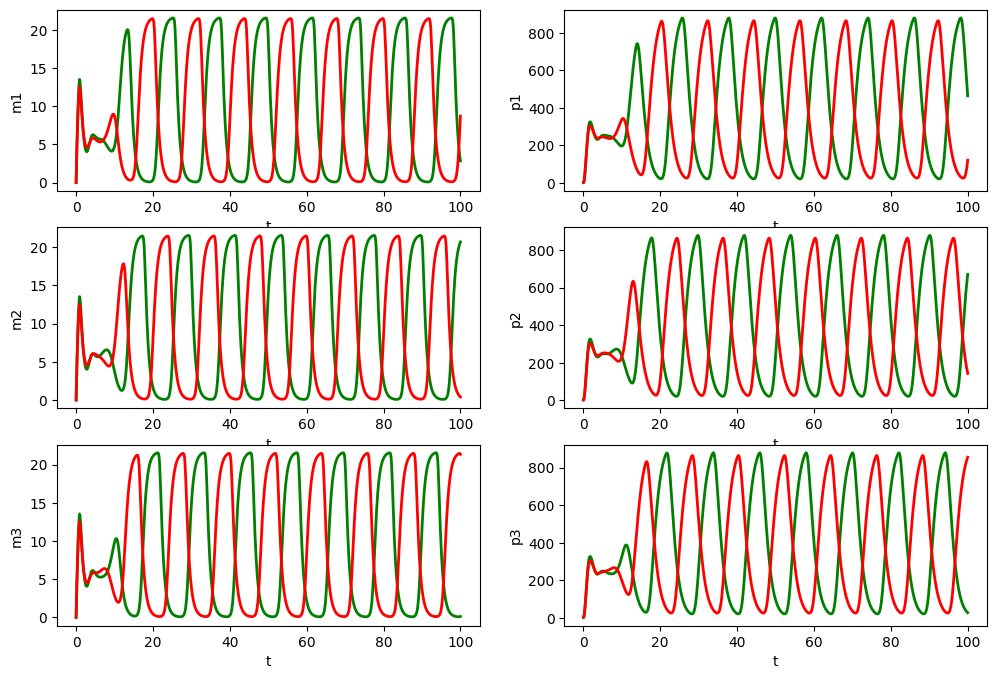

In [34]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 2, figsize=(12, 8))
axs = axs.flatten()

variable_labels = ['m1', 'p1', 'm2', 'p2', 'm3', 'p3']
for i in range(6):
    axs[i].plot(t, true_euler[:, i], linewidth=2, color = "green")
    axs[i].plot(t, x_o[:, i], linewidth=2, color = "red")
    axs[i].set_xlabel('t')
    axs[i].set_ylabel(variable_labels[i])

# Parameter set 2

In [ ]:
#